# Assessing the Impact of Daylight Savings Time on Driving Fatalities

- Anastasiades, Andrew
- Drozdzewicz, Peter
- Garcia, Viera
- Sperry, Taylor
- Surapanemi, Sindhura

### DEPENDENCIES

In [1]:
import pandas as pd #data manipulation
import os #Interoperability
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import datetime as dt

### Multi-Year Graphing
NOTE: This notebook is not designed for legibility. If you would like to see a detailed walkthrough of our data analysis, refer to the 2019 or 2018 notebooks.

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


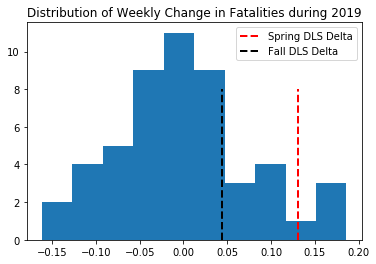

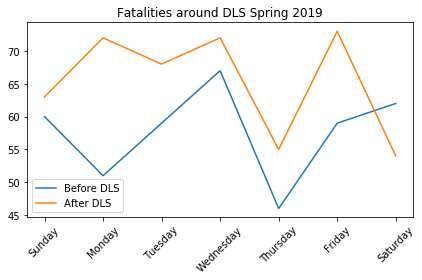

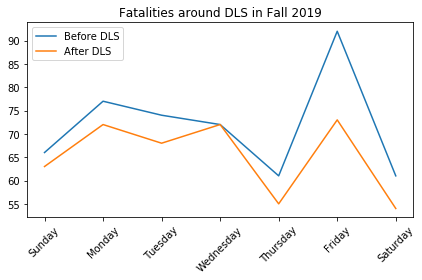

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


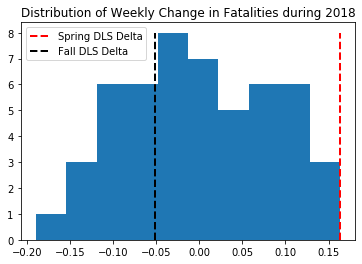

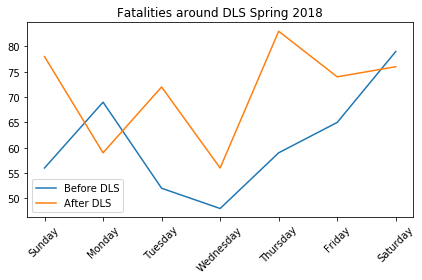

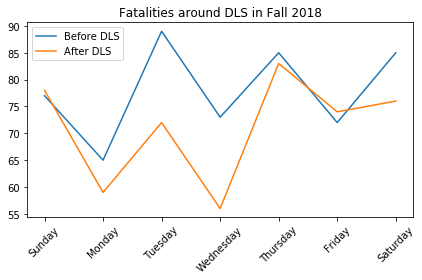

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


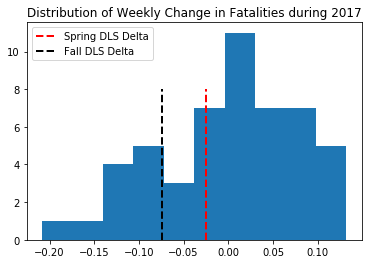

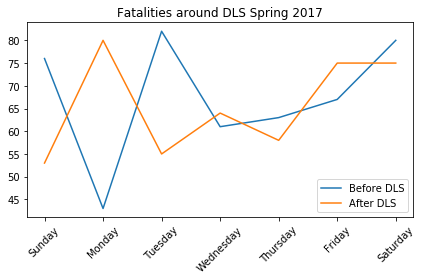

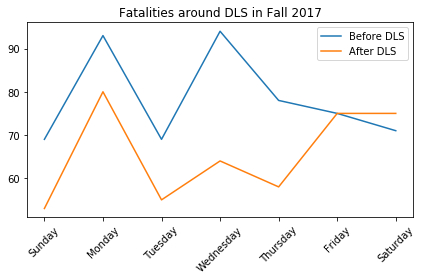

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


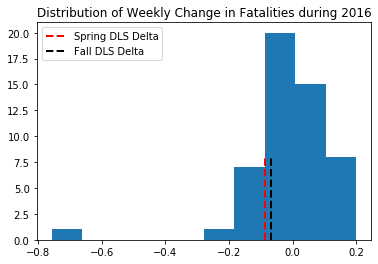

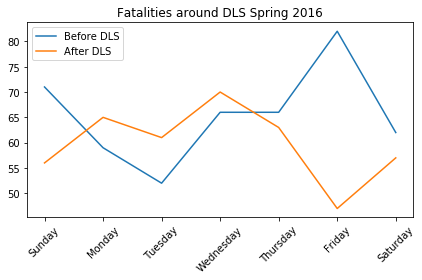

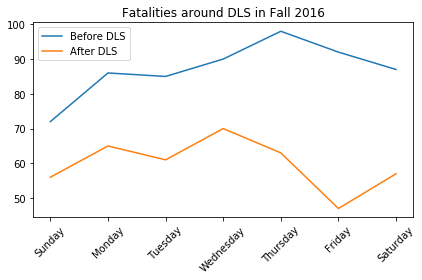

In [2]:
# I made a dict to hold the Day Light Savings Information
year_dict = {
    "2019" : {
        "Y" : 2019,
        "M1" : 3,
        "D1" : 10,
        "M2" : 11,
        "D2" : 3,
    },
    "2018" : {
        "Y" : 2018,
        "M1" : 3,
        "D1" : 11,
        "M2" : 11,
        "D2" : 4,
    },
    "2017" : {
        "Y" : 2017,
        "M1" : 3,
        "D1" : 12,
        "M2" : 11,
        "D2" : 5,
    },
    "2016" : {
        "Y" : 2016,
        "M1" : 3,
        "D1" : 13,
        "M2" : 11,
        "D2" : 6,
    }
}


for year in year_dict.keys():
    dls = year_dict[year] # get the dls dates
    accident_csv = os.path.join("Resources", year+'.csv')

    ## We inspected the original CSV and chose the columns we believed were pertinent
    columns_to_keep = ['STATENAME', 'DAY', 'MONTH','YEAR','HOUR','DAY_WEEK','DAY_WEEKNAME', 'LGT_CONDNAME',
                       'DRUNK_DR', 'WEATHERNAME', 'RUR_URBNAME', 'FATALS',]
    df = pd.read_csv(accident_csv, usecols=columns_to_keep)

    # EXCLUDE DRUNK DRIVERS #Why do we do this?
    df = df[df["DRUNK_DR"]==0] 
    df.drop(axis=1, labels=["DRUNK_DR"], inplace=True)

    # ADD DATE AND WEEKNUM
    # We do this so we can compare week to week changes
    df["DATE"] = pd.to_datetime(df[["YEAR", "MONTH", "DAY"]])
    #df["WEEK_NUM"] = df["DATE"].dt.week
    df['WEEK_NUM'] = df['DATE'].apply(lambda x: (x + dt.timedelta(days=1)).week)
    # SPLIT SAMPLE AND CONTROL
    control_states = ["Arizona", "Hawaii"] #These states do not observe DLS
    control_df = df[df.loc[:,'STATENAME'].isin(control_states)] #NO DLS
    sample_df = df[~df.loc[:,'STATENAME'].isin(control_states)] #DLS
    # GET WEEK BEFORE AND AFTER (March and November)
    mar_week_before = dt.date(dls["Y"],dls["M1"],dls["D1"]).isocalendar()[1] #Determine week of year
    mar_week_after = mar_week_before + 1
    nov_week_before = dt.date(dls["Y"],dls["M2"],dls["D2"]).isocalendar()[1] #Determine week of year
    nov_week_after = nov_week_before + 1
    #GROUP DATA BY WEEK
    week_gb = sample_df.groupby(by=["WEEK_NUM"])
    week_summary = pd.DataFrame(week_gb["FATALS"].sum())
    #week_summary["WEEKLY_CHANGE"]
    weekly_change = []
    for index, row in week_summary.iterrows(): # WE WANT DELTA! FOR EACH WEEK
        if index==1:
            weekly_change.append(np.nan)
        else:
            this_num = week_summary.loc[index, "FATALS"] # FATALITIES FROM THIS WEEK
            last_num = week_summary.loc[index-1, "FATALS"] # FATALITIES FROM LAST WEEK
            delta = (this_num / last_num) - 1
            weekly_change.append(delta)
    week_summary["WEEKLY_CHANGE"] = weekly_change
    week_summary["Z_SCORE"] = st.zscore(weekly_change, nan_policy='omit')
    week_summary.reset_index(inplace=True)
    mar_delta = weekly_change[mar_week_after - 1] #Delta in the week after March DLS
    nov_delta = weekly_change[nov_week_after - 1] #Delta in the week after November DLS
    
    ##FIGURE
    plt.figure()
    plt.hist(week_summary["WEEKLY_CHANGE"])
    plt.title(f"Distribution of Weekly Change in Fatalities during {year}")
    plt.plot([mar_delta,mar_delta], [0, 8], 'r--', lw=2, label="Spring DLS Delta")
    plt.plot([nov_delta,nov_delta], [0, 8], 'k--', lw=2, label="Fall DLS Delta")
    plt.legend()
    plt.savefig(f"Graphs/{year} Delta Distributions.png")
    plt.show()
    
    ### Graphing with DAY_WEEKNAME
    sample_gb = sample_df.groupby(by=["DATE","WEEK_NUM", "DAY_WEEKNAME"])
    summary = pd.DataFrame(sample_gb["FATALS"].sum())
    summary.reset_index(inplace=True)
    before = summary[summary["WEEK_NUM"]==mar_week_before]
    after = summary[summary["WEEK_NUM"]==mar_week_after]
    ## FIGURE
    plt.figure()
    plt.plot(before["DAY_WEEKNAME"], before["FATALS"], label="Before DLS")
    plt.plot(after["DAY_WEEKNAME"], after["FATALS"], label="After DLS")
    plt.xticks(rotation = 45)
    plt.legend()
    plt.title(f"Fatalities around DLS Spring {year}")
    plt.tight_layout()
    plt.savefig(f"Graphs/{year} Spring Fatals.png")
    plt.show()

    #NOVEMBER 2019 - The switch occurs November 3
    week_before = dt.date(2019,11,3).isocalendar()[1] #Determine week of year (starting on Monday)
    week_after = week_before + 1
    sample_gb = sample_df.groupby(by=["DATE","WEEK_NUM", "DAY_WEEKNAME"])
    summary = pd.DataFrame(sample_gb["FATALS"].sum())
    summary.reset_index(inplace=True)
    before = summary[summary["WEEK_NUM"]==nov_week_before]
    after = summary[summary["WEEK_NUM"]==mar_week_after]
    ## FIGURE
    plt.figure()
    plt.plot(before["DAY_WEEKNAME"], before["FATALS"], label="Before DLS")
    plt.plot(after["DAY_WEEKNAME"], after["FATALS"], label="After DLS")
    plt.xticks(rotation = 45)
    plt.legend()
    plt.title(f"Fatalities around DLS in Fall {year}")
    plt.tight_layout()
    plt.savefig(f"Graphs/{year} Fall Fatals.png")
    plt.show()